# WCE

## Principles of the WCE model 

The WCE model is a method used to study the effect of time-dependant exposures where the exposure status and its intensity varies over time. It is based on the notion of cumulated exposure and use convolutions to assign weights of varying intensity to time of past exposure. For a cohort of individuals with each an intensity of dose of a drug X(t), the joint effect of the past exposure is represented as : 

$$
\sum_{t=1}^{u} w(u-t) x(t)
$$

This represent the WCE function, giving weights to the effect of a drug, or any other exposition of varying intensity. 

$$
h(u \mid \mathbf{X}(u), Z(u)) = h_0(u) \exp \left[ \sum_{j=1}^{m} \gamma_j D_j(u) + \sum_{s=1}^{q} \eta_s Z_s(u) \right]
$$

## Connecting to the survivalGPU library



In [1]:
import torch
import os
import sys
import pykeops
import numpy as np
import pykeops

sys.path.append("dev/survivalGPU/python")

os.getcwd()


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


'/home/dev/survivalGPU/python'

## The WCE model on survivalGPU

**wce_R** : the function to run the WCE model on the data

----

**Args**

- **data** : Dataframe, it contain the data analyzed by the model. It need to be a time dependant dataframe where each line correspond to one and only one interval of time

- **covars** : (Optional) Vector of strings, the names of the columns in the dataframe data containing values taken by covariates which effect are not simulated by a cumulated exposure

- **ids** : a string, the name of column in the dataframe data containing the indexes allowing the identification of the subjects 

- **stop** : a string,  the name of column in the dataframe data containing the time at the end of each line

- **doses** : a string,  the name of column in the dataframe data containing the dose of the variable which effect is represented by a cumulative exposure

- **events** : a string,  the name of column in the dataframe data containing 0 if there is no event during a time interval and 1 if there is an event

- **cutoff** : Integer, the time window on which the WCE model is estimated, correspond to the length of the estimated weight function

- **nknots** : Integer, the number of interior knots for the cubic spline to estimate the weight function

- **constrained** : Control whether the weight function should be constrained to smoothly go to 0, Set to False for unconstrained model, to "Right" or "R" to constrained the wight function to tend smoothly to zero for exposure remote in time, and "Left" of "L" to constrained the weight function to start at zero for the current value

- **bootstraps** : (Optional) Integer, the number of bootstraps used in the model

- **batchsize** : (Optional) Integer, only if there is bootstraps, mus be proportional to the number of bootstraps, describe the batchsize of the number of bootstraps that are parallelized on a GPU. It speed up the computation time but for a large number of patients the batchsize must be reduced in order to avoid out of memory errors. The default value is 0, it means that all bootstraps are handled at once

----

**Returns**

A dictionary wth the following values 
If there are bootstraps the values are given in the form of a list of the result for every bootstrap

- **hessian** : list that represents, for each bootstrap, the Hessian of the neg-log-likelihood at the optimum 

- **sctest init** :  tensor of values of the score test at iteration 0

- **loglik init** :  tensor of values of the log-likelihood at iteration 0.

- **lolik** :  tensor of values of the log-likelihood at the optimum

- **coef** : List of the estimated coefficients for the artificial time dependant variables used to fit the WCE model

- **u** : tensor of gradients of the log-likelihood at the optimum (should be close to zero)

- **imat** : tensor that represents, for each bootstrap, the inverse of the Hessian above. This corresponds to an estimated variance matrix for the optimal coefficients

- **means** : means of all the covariates, and of the artificial time dependant variables used to fit the WCE model

- **knotsmat** : The vector of knots used for the spline modelling of the weight function (not a matrix in this implementation as only one knot can be selected, not given for every bootstraps as it is modelled only one time in the current implementation)

- **std** : List of the estimated Standard Error of Difference of the covariates that are not simulated by the WCE

- **SED** : List of the estimated Standard Error of Difference of the artificial time dependant variables used to fit the WCE model

- **WCEmat** : The list of the the values taken by the wight function

- **est** : List of the estimated coefficients for the artificial time dependant variables used to fit the WCE model

- **vcovmat** : List of the variance covariance matrix estimated ???


covariate stuff


## Lacking in results 

- info.criterion : values of the AIC and BIC
- nevent : number of events 

## Duplicate keys

coef and est 
imat and vcovmat





In [2]:
print(result["means"])



NameError: name 'result' is not defined

In [20]:
print(result["std"])


[]


In [19]:
print(result.keys())

dict_keys(['hessian', 'sctest init', 'loglik init', 'loglik', 'coef', 'u', 'imat', 'means', 'knotsmat', 'std', 'SED', 'WCEmat', 'est', 'vcovmat'])


In [1]:
from survivalgpu.simulation import simulate_dataset

dataset = simulate_dataset(max_time = 365, n_patients = 500, doses = [1,1.5,2,2.5,4], 
                           scenario = "exponential_scenario", HR_target = 1.5)


ModuleNotFoundError: No module named 'survivalgpu'

In [172]:
from survivalgpu.wce import wce_R
from survivalgpu.utils import device, float32, int32, int64

# Simulate a dataset for testing



print(dataset.keys())


nknots = 1
batchsize = 100
n_bootsraps = 100
constraint = "Right"
cutoff = 180

# result = wce_torch(ids = patient, doses = doses, events = events, times = start,
#                           cutoff = cutoff, nknots = nknots,covariates = None, 
#                           batchsize = batchsize, bootstrap = n_bootsraps, constrained = constraint,
#                           verbosity = 0
#                           )

result = wce_R(data= dataset, 
               ids = "patients", 
               covars = None,
               stop = "stop",
               doses = "doses", 
               events = "events",
               cutoff = 180,
               nknots = 1,
               constrained = "Right",
               batchsize = 100,
               bootstrap = 100,
               verbosity = )

print(result.keys())



Index(['patients', 'start', 'stop', 'events', 'doses'], dtype='object')
dict_keys(['hessian', 'sctest init', 'loglik init', 'loglik', 'coef', 'u', 'imat', 'means', 'knotsmat', 'std', 'SED', 'WCEmat', 'est', 'vcovmat'])


In [181]:
WCEmat = result["WCEmat"]
print(WCEmat.shape)
print(WCEmat[99])

(100, 180)
[ 3.8135964e-03  3.8472642e-03  3.8761706e-03  3.9004041e-03
  3.9200541e-03  3.9352109e-03  3.9459625e-03  3.9523989e-03
  3.9546089e-03  3.9526834e-03  3.9467094e-03  3.9367783e-03
  3.9229770e-03  3.9053969e-03  3.8841267e-03  3.8592564e-03
  3.8308734e-03  3.7990687e-03  3.7639309e-03  3.7255497e-03
  3.6840136e-03  3.6394128e-03  3.5918367e-03  3.5413734e-03
  3.4881141e-03  3.4321458e-03  3.3735600e-03  3.3124445e-03
  3.2488892e-03  3.1829833e-03  3.1148167e-03  3.0444774e-03
  2.9720559e-03  2.8976405e-03  2.8213221e-03  2.7431883e-03
  2.6633292e-03  2.5818339e-03  2.4987923e-03  2.4142927e-03
  2.3284249e-03  2.2412781e-03  2.1529426e-03  2.0635058e-03
  1.9730586e-03  1.8816900e-03  1.7894886e-03  1.6965439e-03
  1.6029464e-03  1.5087835e-03  1.4141464e-03  1.3191232e-03
  1.2238031e-03  1.1282763e-03  1.0326314e-03  9.3695847e-04
  8.4134564e-04  7.4588298e-04  6.5065990e-04  5.5576488e-04
  4.6128849e-04  3.6731898e-04  2.7394621e-04  1.8125935e-04
  8.9347595e-

In [177]:
vecnum = np.ones(cutoff)
vecdenom = np.zeros(cutoff)
print(HR(result, vecnum, vecdenom))


[1.142950846179136, 0.875725118113903, 1.5188766377961902]


In [145]:
from survivalgpu.wce import wce_R
from survivalgpu.utils import device, float32, int32, int64

# Simulate a dataset for testing



print(dataset.keys())


nknots = 1
batchsize = 100
n_bootsraps = 100
constraint = "Right"
cutoff = 180

# result = wce_torch(ids = patient, doses = doses, events = events, times = start,
#                           cutoff = cutoff, nknots = nknots,covariates = None, 
#                           batchsize = batchsize, bootstrap = n_bootsraps, constrained = constraint,
#                           verbosity = 0
#                           )

dataset = simulate_dataset(max_time = 365, n_patients = 500, doses = [1,1.5,2,2.5,4], 
                           scenario = "exponential_scenario", HR_target = 1.5)

result_1 = wce_R(data= dataset, 
               ids = "patients", 
               covars = None,
               stop = "stop",
               doses = "doses", 
               events = "events",
               cutoff = 180,
               nknots = 2,
               constrained = "Right")




result_2 = wce_R(data= dataset, 
               ids = "patients", 
               covars = None,
               stop = "stop",
               doses = "doses", 
               events = "events",
               cutoff = 180,
               nknots = 2,
               constrained = "Right",
               bootstrap = 100,
               batchsize = 100)



Index(['patients', 'start', 'stop', 'events', 'doses'], dtype='object')
Step 1 : Computing the WCE features... Done in 0.078s.

Step 2 : CoxPH regression... 
Pre-processing:
Working with 1 bootstrap, 1 channels, 234 death times,
52,827 rows (= observations) and 4 columns (= features).

Iteration   1 -- inf
Iteration   2 -- 1.902698e+03
Iteration   3 -- 1.898155e+03
Iteration   4 -- 1.898134e+03
Iteration   5 -- 1.898134e+03
Iteration   6 -- 1.898134e+03
Iteration   7 -- 1.898134e+03
Iteration   8 -- 1.898134e+03
Iteration   9 -- 1.898134e+03
Iteration  10 -- 1.898134e+03
Iteration  11 -- 1.898134e+03
Iteration  12 -- 1.898134e+03
Iteration  13 -- 1.898134e+03
Iteration  14 -- 1.898134e+03
Iteration  15 -- 1.898134e+03
Iteration  16 -- 1.898134e+03
Iteration  17 -- 1.898134e+03
Iteration  18 -- 1.898134e+03
Iteration  19 -- 1.898134e+03
Iteration  20 -- 1.898134e+03
Done in 0.239s.

Step 3 : Post-processing... Done in 0.001s.

Step 1 : Computing the WCE features... Done in 0.078s.

Step

In [141]:
vecnum = np.ones(cutoff)
vecdenom = np.zeros(cutoff)
print(HR(result_1, vecnum, vecdenom))
print(HR(result_2, vecnum, vecdenom))


[1.0389722771891958]
[1.0389807198288434, 0.7930626802409774, 1.3840736505070936]


In [117]:

vecnum = np.ones(cutoff)
vecdenom = np.zeros(cutoff)
print(HR(result, vecnum, vecdenom))

[1.109380481333915]


print(result.keys())


## Plotting the WCE function 

We can plot the wce function in order to verify if the simulation make sens 



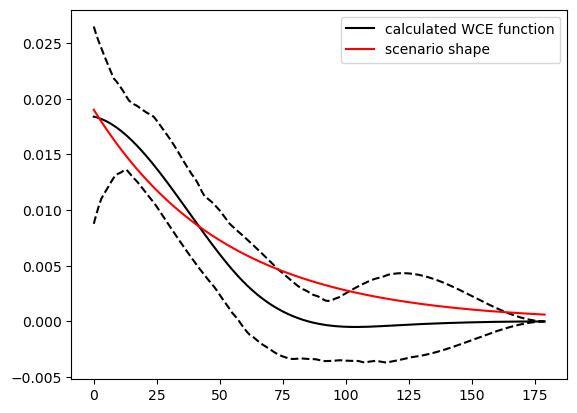

In [156]:
from matplotlib import pyplot as plt
from survivalgpu.simulation import get_scenario
import numpy as np


# get quantiles each column WCEmat

HR_target = 3

WCEmat = result["WCEmat"] /np.log(HR_target)
scenario_shape = get_scenario("exponential_scenario",365)[:180] 

quantiles = np.quantile(WCEmat, [0.025, 0.975], axis = 0)
plt.plot(np.arange(0, 180),WCEmat[0], c = "black", label = "calculated WCE function")
plt.plot(np.arange(0, 180),quantiles[0], c = "black", linestyle = "--")
plt.plot(np.arange(0, 180),quantiles[1], c = "black", linestyle = "--")
plt.plot((np.arange(0, 180)),scenario_shape[:180], c = "red", label = "scenario shape")
plt.legend()


In [49]:

WCEmat = result["WCEmat"]
print(WCEmat.shape[0])

100


In [54]:
def plot_wce(
        WCE_object,
        scenario =None,
        HR_target = None):
    
    WCE_mat = WCE_object["WCEmat"]
            
    plt.plot(np.arange(0, WCEmat.shape[1]),WCE_mat[0], c = "black", label = "calculated WCE function")

    if WCE_mat.shape[0] > 1:
        quantiles = np.quantile(WCE_mat, [0.025, 0.975], axis = 0)
        plt.plot(np.arange(0, WCEmat.shape[1]),quantiles[0], c = "black", linestyle = "--")
        plt.plot(np.arange(0, WCEmat.shape[1]),quantiles[1], c = "black", linestyle = "--")

    
    
    if scenario is not None:
        scenario_shape = get_scenario(scenario,365)[:WCEmat.shape[1]] * np.log(HR_target)
        plt.plot((np.arange(0, WCEmat.shape[1])),scenario_shape[:WCEmat.shape[1]], c = "red", label = "scenario shape")
    
# vecnu
# hr_matrix = np.exp(np.dot(WCEmat, vecnum)) / np.exp(np.dot(WCEmat, vecdenom))
# hr =hr_matrix[0]
# print(hr)
# print()

def HR(WCE_object, vecnum, vecdenom):

    WCEmat = WCE_object["WCEmat"]
    n_bootsraps = WCEmat.shape[0]
    HR_matrix = np.exp(np.dot(WCEmat, vecnum)) / np.exp(np.dot(WCEmat, vecdenom))

    HR = [HR_matrix[0]]
    if n_bootsraps == 1:
        return HR
    
    else:
        HR_quantiles = np.quantile(HR_matrix, [0.025, 0.975], axis = 0)
        HR.append(HR_quantiles[0])
        HR.append(HR_quantiles[1])
        return HR


In [53]:
vecnum = np.ones(180)
vecdenom = np.zeros(180)
HR(result, vecnum, vecdenom)

[1.410406636676834, 1.0135860910940306, 1.7973296594445514]

(100, 180)

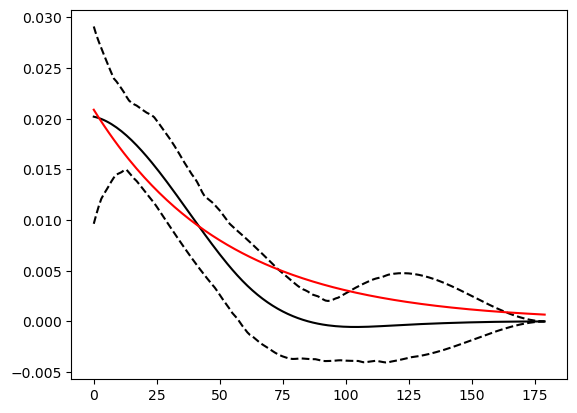

In [160]:
plot_wce(result, scenario = "exponential_scenario", HR_target = 3)
WCEmat.shape

In [21]:
print(result.keys())


dict_keys(['hessian', 'sctest init', 'loglik init', 'loglik', 'coef', 'u', 'imat', 'means', 'knotsmat', 'std', 'SED', 'WCEmat', 'est', 'vcovmat'])
